In [1]:
import numpy as np

import tables as t
import pandas as pd
import os
import json
import datetime
import matplotlib.pyplot as plt


import BKG_Dataholder

%matplotlib inline

## Paths and constants

In [2]:
BEAM_PATH = "/home/mirksonius/Desktop/Fill_info/beam/"
COLLIMATOR_PATH = "/home/mirksonius/Desktop/Fill_info/collimators/"
VACUUM_PATH = "/home/mirksonius/Desktop/Fill_info/vacuum/"
FILL_PATH = "/home/mirksonius/Desktop/22_fills/"
FILL_NUMBER = 8068

vac_vars = [
    "VGI.183.1L5.X.PR",
    "VGI.183.1R5.X.PR",
    "VGI.220.1L5.X.PR",
    "VGI.220.1R5.X.PR"]

### Initializing the bacground dataholder and getting data

In [3]:
bkg = BKG_Dataholder.BKG_dataholder(fill_path = FILL_PATH,
                                    fill_number = FILL_NUMBER,
                                    beam_path = BEAM_PATH,
                                   collimator_path = COLLIMATOR_PATH,
                                   vacuum_path= VACUUM_PATH  
                                   )
bkg.get_beam_data()
bkg.get_fill_data()
bkg.get_vacuum_data()
bkg.get_collimator_data()


Opening file 8068_356436_2207291941_2207291941.hd5
File 8068_356436_2207291941_2207291941.hd5 starts at 2022-07-29 19:41:26 and ends at 2022-07-29 19:42:56
Opening file 8068_356438_2207292019_2207292034.hd5
File 8068_356438_2207292019_2207292034.hd5 starts at 2022-07-29 20:24:35 and ends at 2022-07-29 20:35:07
Empty file : 8068_356438_2207292019_2207292034.hd5
Opening file 8068_356443_2207292034_2207292133.hd5
File 8068_356443_2207292034_2207292133.hd5 starts at 2022-07-29 20:35:08 and ends at 2022-07-29 21:33:25
Empty file : 8068_356443_2207292034_2207292133.hd5
Opening file 8068_356444_2207292133_2207292155.hd5
File 8068_356444_2207292133_2207292155.hd5 starts at 2022-07-29 21:33:27 and ends at 2022-07-29 21:58:51
Opening file 8068_356445_2207292155_2207292159.hd5
File 8068_356445_2207292155_2207292159.hd5 starts at 2022-07-29 21:58:52 and ends at 2022-07-29 22:01:57
Empty file : 8068_356445_2207292155_2207292159.hd5
Opening file 8068_356446_2207292159_2207300202.hd5
File 8068_356446

### Setting up plot start and plot end times 

In [4]:

#Start plotting at beam injection
start_plot = int(bkg.beam_mode["timestamp"].loc[bkg.beam_mode["mode"] == "INJPHYS"].values[0])
end_plot = int(bkg.beam_mode["timestamp"].loc[bkg.beam_mode["mode"] == "RAMPDOWN"].values[0])#bkg.fill_end
print(bkg.fill_start_dt)
print(bkg.fill_end_dt)


2022-07-29 19:52:15
2022-07-30 02:21:42


## Useful functions for plotting beam modes

In [5]:

from datetime import date

#Very useful dictonary for ploting beam modes 
#Will implement an interal dictionary for plotting...
##################################################
#Each beam modes are indicated with numeric values 
# and their colors are chosen arbitrarily
STAGE_COLOR_PALETTE = {
    2 : "firebrick",
    3: "darkgray",
    4: "brown",
    5: "red",   
    6: "yellow",
    7: "darkgreen",
    8 : "mediumslateblue",
    9 : "darkcyan",
    10 : "goldenrod",
    11 : "lime",
    13 : "deepskyblue",
    14 : "cornflowerblue",
    19 : "red",
    21 : "black",
}


def plot_beam_modes(fig,beam_modes,fill_start,fill_stop,set_labels = True):
    """
    Arguments: 
    fig: figure object where to plot
    beam_modes: pandas DataFrame with columns [timestamp, time, cypher, mode]
    #
    timestamp: indicates the time of mesurement
    time: utcdatetime of corresponding timestamp 
    cypher: numeric value of beam mode
    mode: string indicating actual beam mode
    #

    fill_start: timestamp indicating fill start
    fill_stop: timestamp indicating fill end
    """
    N = len(beam_modes["time"])


    for i in range(0,N-1):
        if fill_start > beam_modes["timestamp"].iloc[i] or beam_modes["mode"].iloc[i] == "BEAMDUMP" or beam_modes["mode"].iloc[i] == "RAMPDOWN":
            continue
        if set_labels:
            lab = beam_modes["mode"].iloc[i]
        else:
            lab = None
        fig.axvspan(beam_modes["timestamp"].iloc[i],beam_modes["timestamp"].iloc[i+1],
            color = STAGE_COLOR_PALETTE[beam_modes["cypher"].iloc[i]],
            alpha = 0.3, label = lab
            )
    
    if set_labels:
        lab = beam_modes["mode"].iloc[N-1]
    else:
        lab = None

    #These are usually too short to be seen as regions of
    #graph so they are removed for clarity
    if beam_modes["mode"].iloc[N-1] == "BEAMDUMP" or beam_modes["mode"].iloc[N-1] == "RAMPDOWN":
        return
    fig.axvspan(beam_modes["timestamp"].iloc[N-1],fill_stop,
        color = STAGE_COLOR_PALETTE[beam_modes["cypher"].iloc[N-1]],
        alpha = 0.3, label = lab
        )




def get_xlabels(timestamps):
    """
        Gets label timestamps for x axis labels in UTC time
        Arguments:
        timestamps: iterable of locations where timesamp labels should
        be placed.
    """
    dates = []
    for t in timestamps:
        d = datetime.datetime.utcfromtimestamp(t)
        dates.append(
            datetime.time(hour = d.hour,
                            minute= d.minute,
                            second= d.second
                                )
        )
    return dates


### Getting centere of mass energy in TeV
#### Should be implemented in a general class

In [6]:
sqrt_s = (bkg.energy_b1["value"].values.max() + bkg.energy_b2["value"].values.max())/1000
sqrt_s

13.599599609375

## Plotting two-figure graphs

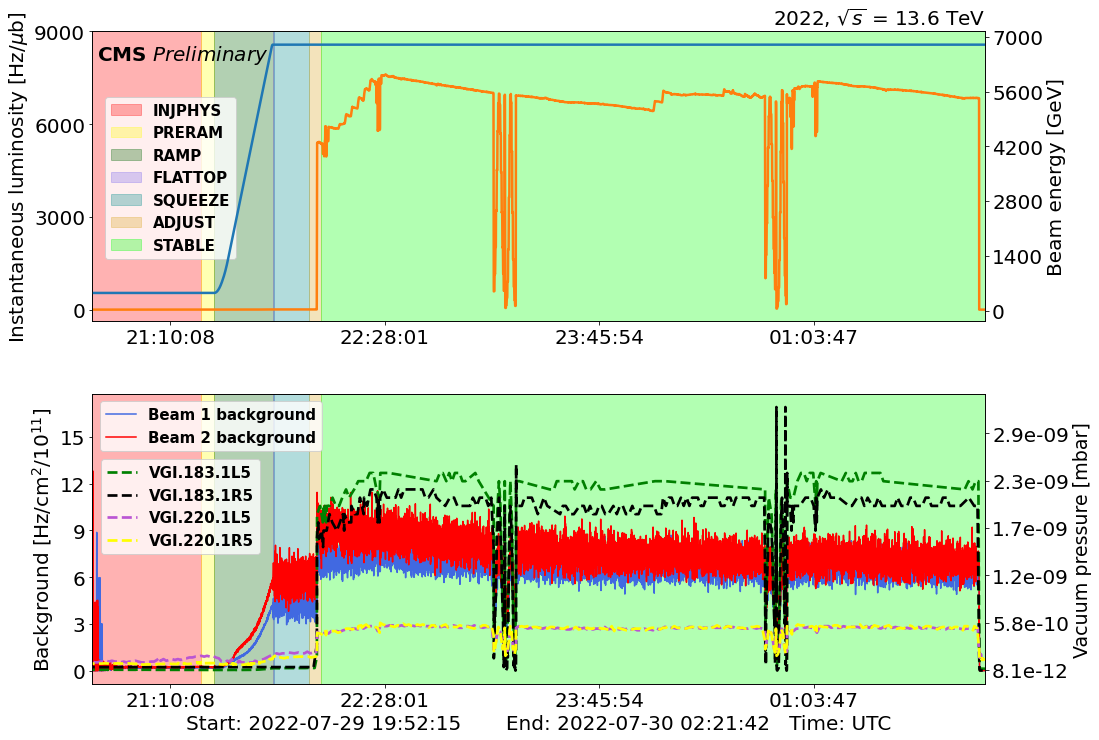

In [13]:

legend_properties = {'weight':'bold',"size":15}

frame, fig = plt.subplots(2,1, figsize = (16,12))

fig[0].plot(bkg.times,bkg.lumi,color = "tab:orange",linewidth = 2.5)
fig0_tw = fig[0].twinx()
fig[0].set_ylabel(r"Instantaneous luminosity [Hz/$\mu$b]",fontsize = 20)
fig0_tw.plot(bkg.energy_b1["timestamp"],bkg.energy_b1["value"],color = "tab:blue",linewidth = 2.5)
fig0_tw.set_ylabel("Beam energy [GeV]",fontsize = 20)

plot_beam_modes(fig[0],bkg.beam_mode,start_plot,end_plot)
plot_beam_modes(fig[1],bkg.beam_mode,start_plot,end_plot,set_labels = False)
#plot_beam_modes(fig[2],bkg.beam_mode,bkg.fill_start,bkg.fill_end)


fig[0].legend(bbox_to_anchor = (0.17,0.80),prop = legend_properties,)
fig[0].set_title(f"2022, " + r"$\sqrt{s}$" + " = {:.1f} TeV".format(sqrt_s) ,
loc = "right", fontsize = 20,)

t0 = np.min(bkg.energy_b1["timestamp"])
t1 = np.max(bkg.energy_b1["timestamp"])
ticks = np.linspace(t0,t1,6,endpoint=True,dtype="int")
lab = get_xlabels(ticks)
fig[0].set_xticks(ticks)
fig[0].set_xticklabels(lab,fontsize = 20)
yt_0 = np.arange(0,7000 + 3000,3000)
fig[0].set_yticks(yt_0)
fig[0].set_yticklabels(yt_0,fontsize = 20)
yt_1 = np.arange(0,7000 + 1400,1400)

fig0_tw.set_yticks(yt_1)
fig0_tw.set_yticklabels(yt_1,fontsize = 20)
plt.text(0.005, 0.9, r"$\bf{CMS}$ $\it{Preliminary}$",fontsize = 20, transform=fig[0].transAxes)


fig[0].set_xlim(start_plot,end_plot)

fig[1].plot(bkg.times,bkg.plusz,color = "royalblue",label = "Beam 1 background",)
fig[1].plot(bkg.times,bkg.minusz,color = "red",label = "Beam 2 background")

fig1_tw = fig[1].twinx()

fig[1].set_ylabel(r"Background [Hz/cm$^2$/10$^{11}$]",fontsize = 20)
fig[1].set_xticks(ticks)
fig[1].set_xticklabels(lab,fontsize = 20)
fig[1].set_xlim(start_plot,end_plot)


clr = ["green","black","mediumorchid","yellow"]
for i,var in enumerate(vac_vars):
    fig1_tw.plot(bkg.vac_dict[var]["timestamp"],
                bkg.vac_dict[var]["value"],
                color = clr[i],
                linewidth = 2.7,
                linestyle = "--",
                label = var.replace(".X.PR", ""))



vac0 = np.min(bkg.vac_dict[vac_vars[0]]["value"])
vac1 = np.max(bkg.vac_dict[vac_vars[0]]["value"])
vac_ticks = np.linspace(vac0, 1.2*vac1,6,dtype="float")
vac_labs = ["{:.1e}".format(v) for v in vac_ticks]
fig1_tw.set_yticks(vac_ticks)
fig1_tw.set_yticklabels(vac_labs,fontsize = 20)
fig1_tw.set_ylabel("Vacuum pressure [mbar]",fontsize = 19)

legend_properties = {'weight':'bold',"size":15}
legend_properties_tw = {'weight':'bold',"size":15}


fig[1].legend(loc = "upper left",prop = legend_properties)#,bbox_to_anchor = (0.25,0.80))
fig1_tw.legend(loc = "upper left",bbox_to_anchor = (0.001,0.8,0,0),prop = legend_properties_tw)


yt_2 = np.arange(0,18,3)
fig[1].set_yticks(yt_2)
fig[1].set_yticklabels(yt_2,fontsize = 20)

fig[1].set_xlabel( "Start: {}       End: {}   Time: UTC".format(
    bkg.fill_start_dt,
    bkg.fill_end_dt
    ),fontsize = 20)

plt.subplots_adjust(hspace = 0.25)
plt.savefig("background_two_graphs.pdf")


## Plotting much nicer three figure graphs

[1.65912434e+09 1.65912434e+09 1.65912434e+09 ... 1.65914770e+09
 1.65914770e+09 1.65914770e+09]


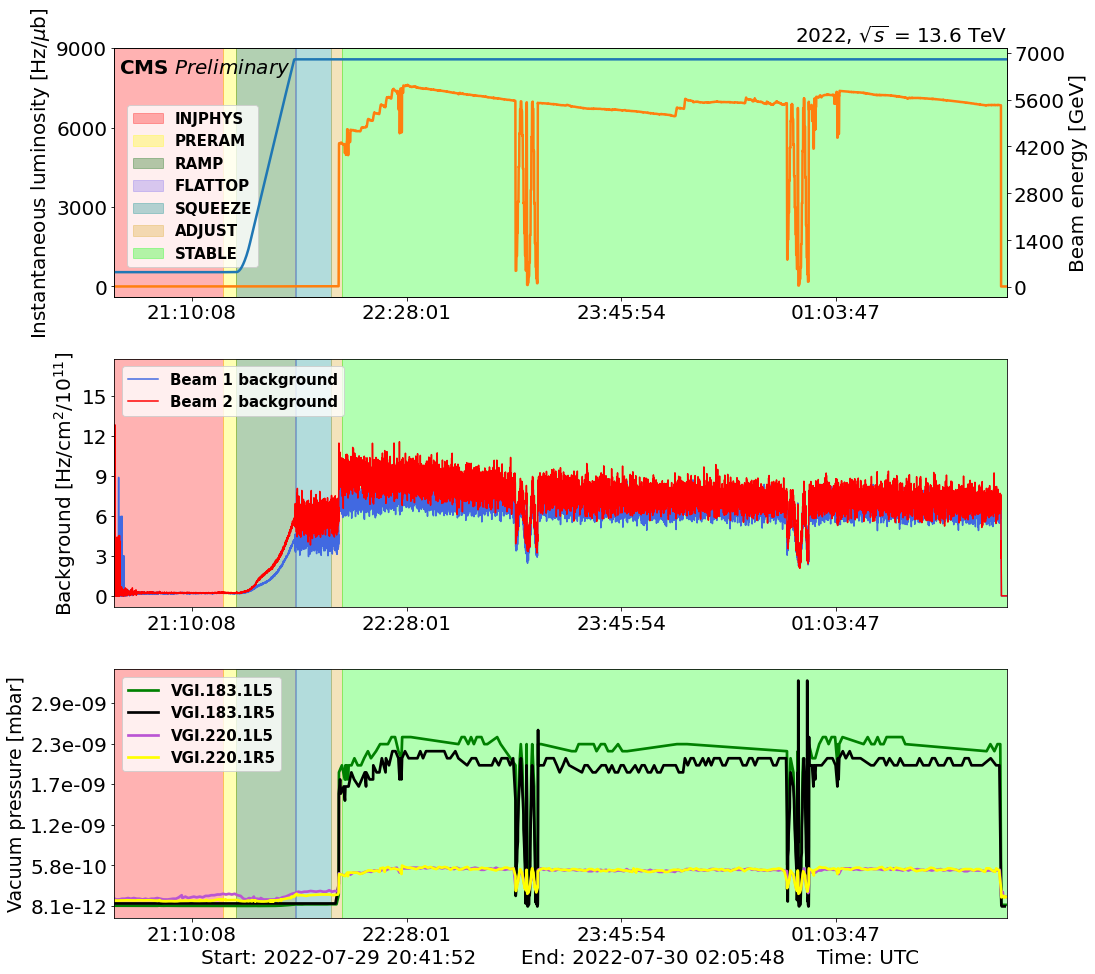

In [8]:

legend_properties = {'weight':'bold',"size":15}

frame, fig = plt.subplots(3,1, figsize = (16,16))

fig[0].plot(bkg.times,bkg.lumi,color = "tab:orange",linewidth = 2.5)
fig0_tw = fig[0].twinx()
fig[0].set_ylabel(r"Instantaneous luminosity [Hz/$\mu$b]",fontsize = 20)
fig0_tw.plot(bkg.energy_b1["timestamp"],bkg.energy_b1["value"],color = "tab:blue",linewidth = 2.5)
fig0_tw.set_ylabel("Beam energy [GeV]",fontsize = 20)

plot_beam_modes(fig[0],bkg.beam_mode,start_plot,end_plot)
plot_beam_modes(fig[1],bkg.beam_mode,start_plot,end_plot,set_labels = False)
plot_beam_modes(fig[2],bkg.beam_mode,start_plot,end_plot,set_labels = False)


fig[0].legend(bbox_to_anchor = (0.17,0.80),prop = legend_properties,)
fig[0].set_title(f"2022, " + r"$\sqrt{s}$" + " = {:.1f} TeV".format(sqrt_s) ,
loc = "right", fontsize = 20,)

t0 = np.min(bkg.energy_b1["timestamp"])
t1 = np.max(bkg.energy_b1["timestamp"])
print(bkg.energy_b1["timestamp"].values)
ticks = np.linspace(t0,t1,6,endpoint=True,dtype="int")
lab = get_xlabels(ticks)
fig[0].set_xticks(ticks)
fig[0].set_xticklabels(lab,fontsize = 20)
yt_0 = np.arange(0,7000 + 3000,3000)
fig[0].set_yticks(yt_0)
fig[0].set_yticklabels(yt_0,fontsize = 20)
yt_1 = np.arange(0,7000 + 1400,1400)

fig0_tw.set_yticks(yt_1)
fig0_tw.set_yticklabels(yt_1,fontsize = 20)
plt.text(0.005, 0.9, r"$\bf{CMS}$ $\it{Preliminary}$",fontsize = 20, transform=fig[0].transAxes)


fig[0].set_xlim(start_plot,end_plot)

fig[1].plot(bkg.times,bkg.plusz,color = "royalblue",label = "Beam 1 background",)
fig[1].plot(bkg.times,bkg.minusz,color = "red",label = "Beam 2 background")


fig[1].set_ylabel(r"Background [Hz/cm$^2$/10$^{11}$]",fontsize = 20)
fig[1].set_xticks(ticks)
fig[1].set_xticklabels(lab,fontsize = 20)
fig[1].set_xlim(start_plot,end_plot)

fig1_tw =fig[2]
clr = ["green","black","mediumorchid","yellow"]
for i,var in enumerate(vac_vars):
    fig1_tw.plot(bkg.vac_dict[var]["timestamp"],
                bkg.vac_dict[var]["value"],
                color = clr[i],
                linewidth = 2.7,
                linestyle = "-",
                label = var.replace(".X.PR", ""))



vac0 = np.min(bkg.vac_dict[vac_vars[0]]["value"])
vac1 = np.max(bkg.vac_dict[vac_vars[0]]["value"])
vac_ticks = np.linspace(vac0, 1.2*vac1,6,dtype="float")
vac_labs = ["{:.1e}".format(v) for v in vac_ticks]
fig1_tw.set_yticks(vac_ticks)
fig1_tw.set_yticklabels(vac_labs,fontsize = 20)
fig1_tw.set_ylabel("Vacuum pressure [mbar]",fontsize = 19)
fig1_tw.set_xticks(ticks)
fig1_tw.set_xticklabels(lab,fontsize = 20)
fig1_tw.set_xlim(start_plot,end_plot)





legend_properties = {'weight':'bold',"size":15}
legend_properties_tw = {'weight':'bold',"size":15}


fig[1].legend(prop = legend_properties, loc = "upper left")
fig1_tw.legend(loc = "upper left",bbox_to_anchor = (0.001,1,0,0),prop = legend_properties_tw)


yt_2 = np.arange(0,18,3)
fig[1].set_yticks(yt_2)
fig[1].set_yticklabels(yt_2,fontsize = 20)
fig1_tw.set_xlabel("Start: {}       End: {}     Time: UTC".format(datetime.datetime.utcfromtimestamp(start_plot),
    datetime.datetime.utcfromtimestamp(end_plot) ),
    fontsize = 20)




#for key in bkg.coll_dict.keys():
#    for t in bkg.coll_dict[key][key + bkg.collimator_variables[0]]["timestamp"]:
#        fig[1].axvline(t,color = "black",linestyle = "--")


plt.subplots_adjust(hspace = 0.25)
plt.savefig("background_three_graphs.pdf")



# Future ideas on background, collimator, vacuum, (afterglow) work
### Make a dataframe containing background for plus and minus side. 
### Add columns indicating collimaotr positons, vaccum measurements and beam modes.
### Correlate background with collimator variables, vacuum variables aat each beam mode?

## Corellating Vacuum with Background

(14115,)
VGI.183.1L5.X.PR
(14115,)
0.0


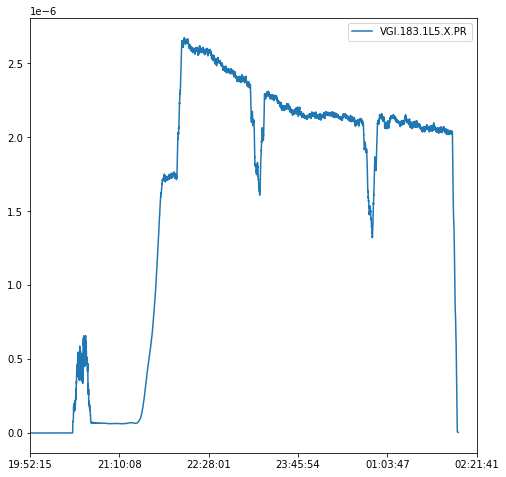

In [9]:
var = vac_vars[1]

frame,fig = plt.subplots(figsize = (8,8))
    
print(bkg.times.shape)
v = bkg.minusz #- np.mean(bkg.minusz)

for var in vac_vars:    
    print(var)
    a = bkg.vac_dict[var]["value"].loc[bkg.vac_dict[var]["timestamp"] >= bkg.fill_start]
    conv = np.correlate(v,a, mode = "same")
    print(conv.shape)
    fig.plot(bkg.times,conv,label = var)
    break
    
fig.set_xticks(ticks)
fig.set_xticklabels(lab)

fig.set_xlim(bkg.fill_start,bkg.fill_end)

fig.legend()
print(conv[0])


In [10]:
print(bkg.collimator_variables)
for key in bkg.coll_dict.keys():
    print(key + bkg.collimator_variables[0])
    print(bkg.coll_dict[key][key + bkg.collimator_variables[0]])

[':SET_LD', ':SET_RD']
TCTPH.4L5.B1:SET_LD
   position     timestamp                          time
0   25.0000  1.659124e+09 2022-07-29 19:53:12.552875996
1   11.2315  1.659125e+09 2022-07-29 19:56:59.307031870
2    6.8200  1.659133e+09 2022-07-29 22:11:05.277363539
3    6.8150  1.659133e+09 2022-07-29 22:18:00.979738712
4    6.8200  1.659141e+09 2022-07-30 00:30:44.740972996
5    6.8200  1.659148e+09 2022-07-30 02:21:42.000000000
TCTPV.4L5.B1:SET_LD
   position     timestamp                          time
0   25.0000  1.659124e+09 2022-07-29 19:53:12.530488490
1    9.9342  1.659125e+09 2022-07-29 19:56:59.268967152
2    9.9342  1.659148e+09 2022-07-30 02:21:42.000000000
TCL.4R5.B1:SET_LD
   position     timestamp                          time
0   27.0000  1.659124e+09 2022-07-29 19:53:12.530488490
1   24.9998  1.659125e+09 2022-07-29 19:56:59.315019131
2   12.4150  1.659133e+09 2022-07-29 22:11:05.277363539
3   12.4100  1.659133e+09 2022-07-29 22:15:34.778988600
4   12.4150  1.659141e+

In [11]:

df = bkg.coll_dict[bkg.collimators_b1[0]][bkg.collimators_b1[0] + bkg.collimator_variables[0]]

ch_t = df["timestamp"]
ch_pos = df["position"]
